# Exploratory Data Analysis

## 1. Setup

In [15]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

DATA_DIR = pathlib.Path("../../data/cell2cell")

## 2. Download and load the data

In [6]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jpacse/datasets-for-churn-telecom")
print("Path to dataset files:", path)

100%|███████████████████████████████| 3.92M/3.92M [00:00<00:00, 7.65MB/s]

Extracting files...


Path to dataset files: /Users/wenyechen/.cache/kagglehub/datasets/jpacse/datasets-for-churn-telecom/versions/2


In [16]:
train_df = pd.read_csv(DATA_DIR / 'cell2celltrain.csv')
test_df=pd.read_csv(DATA_DIR / 'cell2cellholdout.csv')

In [17]:
print(f"shape is: {train_df.shape}")
train_df.head()

shape is: (51047, 58)


,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


## 3. Data analysis

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

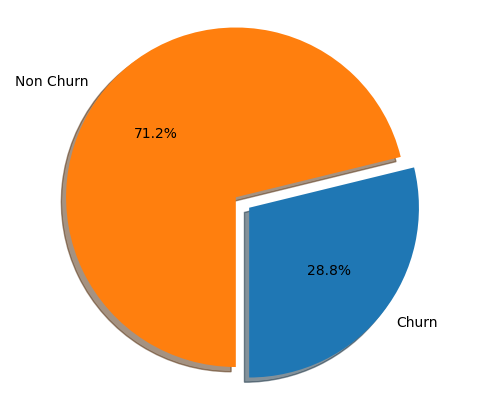

In [35]:
churn=train_df[train_df['Churn']=='Yes'].shape[0]
non_churn= train_df[train_df['Churn']=='No'].shape[0]

slices=[churn,non_churn]
labels=['Churn','Non Churn']
explode=[0.1,0]

fig1, ax1 = plt.subplots(figsize=(6, 5))
ax1.pie(slices, explode=explode, labels=labels,autopct='%1.1f%%',shadow=True, startangle=270)
ax1.axis('equal')  
plt.show()

In [57]:
tenure_yes = (
    train_df.loc[train_df.Churn == 'Yes', 'MonthsInService']
             .value_counts()
             .rename('Churn')
)

tenure_no  = (
    train_df.loc[train_df.Churn == 'No', 'MonthsInService']
             .value_counts()
             .rename('NoChurn')
)

tenure = (
    pd.concat([tenure_yes, tenure_no], axis=1)
      .fillna(0)                 # replace NaNs with 0
      .sort_index()              # tenure on the x-axis in order
      .astype(int)
      .reset_index()                 # ← converts the index into a column
      .rename(columns={'index': 'MonthsInService'})
)

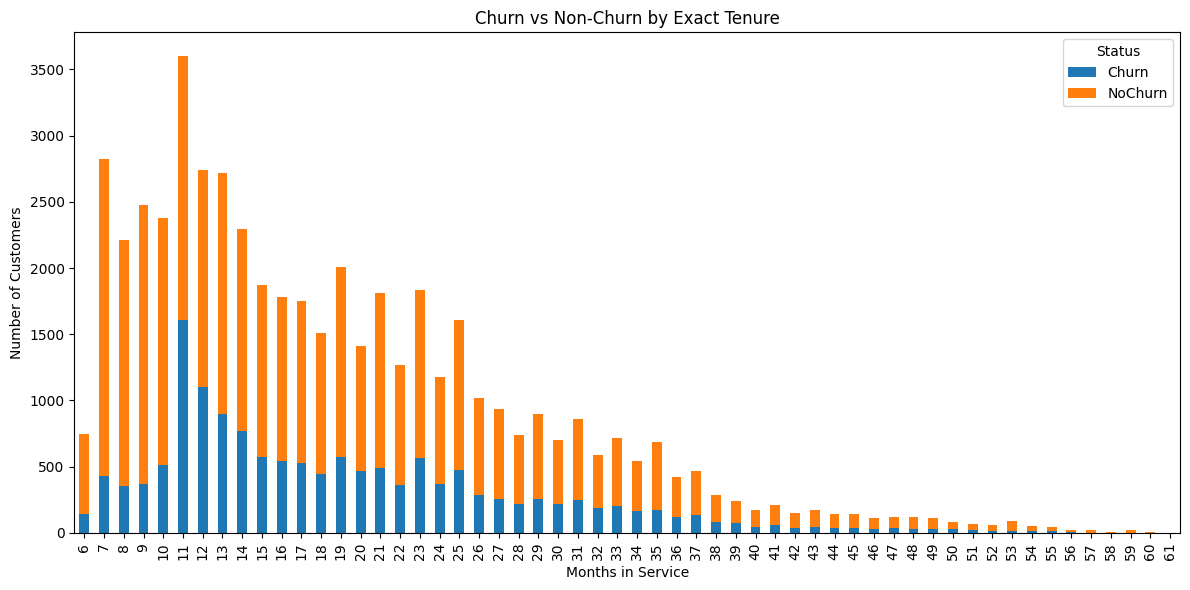

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
tenure.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('Months in Service')
ax.set_ylabel('Number of Customers')
ax.set_title('Churn vs Non-Churn by Exact Tenure')
ax.legend(title='Status')

plt.tight_layout()
plt.show()

/var/folders/w_/bd5qzspx3kvg9_g_7l7s3z000000gn/T/ipykernel_9330/381780495.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure.groupby('TenureBin')[['Churn', 'NoChurn']]


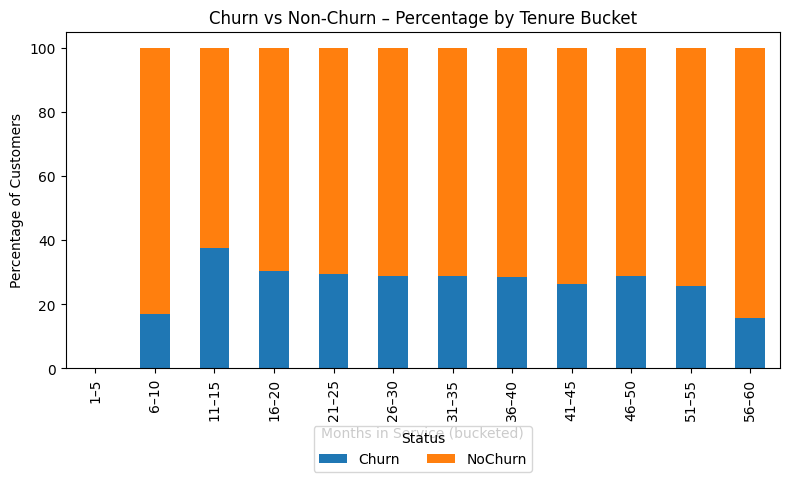

In [70]:
bins   = list(range(0, 65, 5))           # [0, 5, 10, …, 60]
labels = [f'{i+1}–{i+5}' for i in bins[:-1]]   # ['1–5', '6–10', …, '56–60']

tenure['TenureBin'] = pd.cut(
    tenure['MonthsInService'],
    bins=bins,
    labels=labels,
    right=True,        # right edge is inclusive, so 10 falls into 1-10
    include_lowest=True
)

bucket_counts = (
    tenure.groupby('TenureBin')[['Churn', 'NoChurn']]
          .sum()                       # raw counts per bucket
)

bucket_pct = (
    bucket_counts
      .div(bucket_counts.sum(axis=1), axis=0)   # divide by bucket total
      .mul(100)                                 # convert to %
      .round(2)
)

fig, ax = plt.subplots(figsize=(8, 5))

bucket_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax
)

ax.set_ylabel('Percentage of Customers')
ax.set_xlabel('Months in Service (bucketed)')
ax.set_title('Churn vs Non-Churn – Percentage by Tenure Bucket')
ax.legend(title='Status', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()

## Data analysis summary
1. Non-churn vs Churn is 71.2% VS 28.8%. The dataset is imbalanced.
2. Churn rate peaking right after the first-year mark and steadily falling with tenure

In [ ]:
# 3 Feature engineering

In [ ]:
# 4 Exploratory plots

In [ ]:
# 5 Baseline model

In [ ]:
# 6 Train/test split and report

In [ ]:
# 7 Save clean dataset for later notebooks

In [ ]:
# 8 Save train/test splits for later notebooks